### Extracting data from the JSON files

In [8]:
import numpy as np
import json 
import pandas

business_ratings = { }
for line in open("data/yelp_academic_dataset_business.json", "r"):
    json_data = json.loads(line)
    business_ratings[json_data["business_id"]] = json_data["stars"]
selected_businesses = set(np.random.choice(business_ratings.keys(), size = 2000, replace = False))
    
review_list = []
for line in open("data/yelp_academic_dataset_review.json", "r"):
    json_data = json.loads(line)
    if json_data["business_id"] in selected_businesses:
        review_list.append([json_data["review_id"], json_data["stars"], json_data["text"], json_data["business_id"]])
review_pd = pandas.DataFrame(review_list, columns = ["Review ID", "Stars", "Review Text", "Business ID"])

### Tokenizing the review text

In [9]:
import sys
import string
import unicodedata
from nltk.tokenize import RegexpTokenizer

tbl = dict.fromkeys(i for i in xrange(sys.maxunicode) if unicodedata.category(unichr(i)).startswith('P'))

def tokenize(text):
    return text.translate(tbl).lower().split()

review_pd["Tokenized Text"] = review_pd["Review Text"].apply(tokenize)

In [10]:
review_pd.head()

,Review ID,Stars,Review Text,Business ID,Tokenized Text
0,8LsVRhZ_L9lbQHHlGumuxg,4,It was my first time here. Was recommended by...,LG_Dgv7u7P2ASDWU1RAyWQ,"[it, was, my, first, time, here, was, recommen..."
1,DkVXO2Dt3jqZxRpWGGjWrg,2,The problem I have this experience compared to...,LG_Dgv7u7P2ASDWU1RAyWQ,"[the, problem, i, have, this, experience, comp..."
2,FL-WSGL0-zxer_WcGxyP-w,4,"As not only pet-owners, but as dog breeders le...",LG_Dgv7u7P2ASDWU1RAyWQ,"[as, not, only, petowners, but, as, dog, breed..."
3,xS95092Dl_DbSVMtF-FPRA,5,I only allow my dogs to go to Dr. Bezak. I've ...,LG_Dgv7u7P2ASDWU1RAyWQ,"[i, only, allow, my, dogs, to, go, to, dr, bez..."
4,QR7FE4f9PI0iXcXXtgjUWQ,1,We had the worst possible experience at the Ea...,eznh0XjVtv924K-KYx_ilQ,"[we, had, the, worst, possible, experience, at..."


### Manipulating data into LabeledSentences

In [35]:
from gensim.models.doc2vec import LabeledSentence
import numpy as np

class LabeledSentences:
    
    def __init__(self, series):
        self.series = series
        
    def __iter__(self):
        indexes = list(np.arange(len(self.series)))
        np.random.shuffle(indexes)
        for (index, wordlist) in self.series.iloc[indexes].iteritems():
            yield LabeledSentence(words = wordlist, tags = ['VEC_%s' % index])
            
sentences = LabeledSentences(review_pd["Tokenized Text"].copy())

### Learn vector representations for each word via Word2Vec

In [37]:
import multiprocessing
import gensim
from gensim.models import Doc2Vec

assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be slow otherwise"
cores = multiprocessing.cpu_count()

model = Doc2Vec(dm = 1, dm_concat = 0, min_count = 1, window = 10, size = 150, sample = 1e-4, negative = 5, 
                workers = cores, alpha = 0.025, min_alpha = 0.025)
model.build_vocab(sentences)

### Learn vector representations for each review text via Doc2Vec

In [38]:
for epoch in range(20):
    model.train(sentences)
    model.alpha -= 0.002
    model.min_alpha = model.alpha

### Concatenate Review Rating with Vector

In [97]:
design_matrix, labels = [], []
test_matrix, t_labels = [], []

for index in xrange(len(model.docvecs)):
    key = ("VEC_%s") % (index)
    if index < 10500:
        design_matrix.append(np.append(model.docvecs[key], review_pd["Stars"][index]))
        labels.append(business_ratings[review_pd["Business ID"][index]])
    else:
        test_matrix.append(np.append(model.docvecs[key], review_pd["Stars"][index]))
        t_labels.append(business_ratings[review_pd["Business ID"][index]])
    
design_matrix = np.array(design_matrix)
labels = (np.array(labels) > 3).astype(int)

test_matrix = np.array(test_matrix)
t_labels = (np.array(t_labels) > 3).astype(int)

### Input data into Binomial Model

In [98]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(design_matrix, labels)

preds = logreg.predict(test_matrix)
print np.mean(preds == t_labels)

0.962


### Input data into Multiclass Logistic Regression Model

In [70]:
design_matrix, labels = [], []
test_matrix, t_labels = [], []

star_mapping = { }
for index in xrange(0, 9):
    star_mapping[index * 0.5 + 1] = index

for index in xrange(len(model.docvecs)):
    key = ("VEC_%s") % (index)
    if index < 45000:
        design_matrix.append(np.append(model.docvecs[key], review_pd["Stars"][index]))
        labels.append(star_mapping[business_ratings[review_pd["Business ID"][index]]])
    else:
        test_matrix.append(np.append(model.docvecs[key], review_pd["Stars"][index]))
        t_labels.append(star_mapping[business_ratings[review_pd["Business ID"][index]]])
    
design_matrix = np.array(design_matrix)
labels = np.array(labels).astype(int)

test_matrix = np.array(test_matrix)
t_labels = np.array(t_labels).astype(int)

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

logreg = LogisticRegression(multi_class = "multinomial", solver = "lbfgs")
logreg.fit(design_matrix, labels)

preds = logreg.predict(test_matrix)
print np.mean(abs(t_labels - preds))
print mean_squared_error(preds, t_labels) ** 0.5

1.06588176353
1.3910859932


(array([   62.,    72.,    93.,   316.,   882.,  1276.,  2403.,  1862.,
         1018.]),
 array([ 0.        ,  0.88888889,  1.77777778,  2.66666667,  3.55555556,
         4.44444444,  5.33333333,  6.22222222,  7.11111111,  8.        ]),
 <a list of 9 Patch objects>)

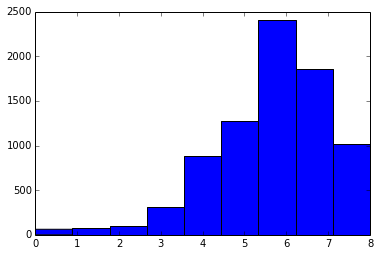

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(t_labels, bins = 9)

In [79]:
stars = np.array(business_ratings.values())
(stars == 3).sum()

8335